<a href="https://colab.research.google.com/gist/ashwinkey04/de066da294792f198b7f74ad6ec702e8/fyp_phase_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 1

> Gathering news articles and stock prices for a specific stock and preparing the dataset for sentiment analysis and stock value prediction


#### How it works
> This notebook fetches daily stock market data of a specified stock from [yfinance](https://www.yahoofinanceapi.com/) api and its daily news articles from [mediastack](https://mediastack.com/) api and creates a derived dataset which contains **news sentiment**. This notebook can be scheduled to run daily on Google Cloud Run to gather data daily




#### Structure of dataset generated

1. stock_history.csv
2. news.json
3. news_sentiment.csv

#### stock_history.csv 

1. Date - Trading date
2. Open - Open price of day
3. High - Highest price of day
4. Low - Lowest price of day
5. Close - Closing price of day
6. Volume - Amount of asset/security 
7. Dividends - Distribution of stock
8. Stock splits - Shares of stock to its current shareholders


#### news.json

1. author - author of news article 
2. title - title of news article 
3. description - description of news article
4. url - url of news article
5. source - source of news article
6. image - image of news article
7. category - category of news article
8. language - language of news article
9. country - country name
10. published_at - published date

#### news_sentiment.csv

1. published_at - published date
2. title - title of news article 
3. description - description of news article
4. url - url of news article
5. sentiment - news sentiment
6. sentiment_score - news sentiment score between 0 to 1



## Installing packages


In [1]:
# Install Yahoo Finance package
%pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [70]:
# Install Google cloud helper package
%pip install firebase-admin

  Using cached firebase_admin-6.0.1-py3-none-any.whl (119 kB)
  Using cached google_api_python_client-2.74.0-py2.py3-none-any.whl (10.9 MB)
  Using cached CacheControl-0.12.11-py2.py3-none-any.whl (21 kB)
  Using cached google_cloud_storage-2.7.0-py2.py3-none-any.whl (110 kB)
  Using cached google_api_core-2.11.0-py3-none-any.whl (120 kB)
  Using cached google_cloud_firestore-2.9.1-py2.py3-none-any.whl (265 kB)
  Using cached protobuf-4.21.12-cp37-abi3-macosx_10_9_universal2.whl (486 kB)
  Using cached google_auth-2.16.0-py2.py3-none-any.whl (177 kB)
  Using cached googleapis_common_protos-1.58.0-py2.py3-none-any.whl (223 kB)
  Using cached grpcio_status-1.51.1-py3-none-any.whl (5.1 kB)
  Using cached google_auth_httplib2-0.1.0-py2.py3-none-any.whl (9.3 kB)
  Using cached google_cloud_core-2.3.2-py2.py3-none-any.whl (29 kB)
  Using cached google_resumable_media-2.4.1-py2.py3-none-any.whl (77 kB)
  Using cached google_crc32c-1.5.0-cp38-cp38-macosx_10_9_universal2.whl (32 kB)
  Attemptin

In [2]:
# Install Transformers package for transfer learning
%pip install transformers

#Install pmdarima package for ARIMA
%pip uninstall pmdarima

Note: you may need to restart the kernel to use updated packages.


## Importing packages

In [1]:
# Import other libraries 
import yfinance as yf
import pandas as pd
import numpy as np
import os
import json
import datetime
from datetime import date,timedelta
import warnings
import http.client, urllib.parse

warnings.filterwarnings("ignore")
from transformers import AutoTokenizer, AutoModelForSequenceClassification,pipeline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

## Define parameters

In [ ]:
# company symbol and name
company_symbol="RELIANCE.NS"
company_name="Reliance"

In [62]:

#Initialise today date
today = str(date.today())
yesterday = str(date.today()- timedelta(days = 1))

# flag variables
news_inserted=False

#secret key of mediastack api
mediastack_api_token = "9f774391108184659c6eecd8dfdcd269"

# input file paths
stock_history_file_path='./input/{}_stock_history.csv'.format(company_name)
news_file_path='./input/{}_news.json'.format(company_name)
news_sentiment_file_path='./input/{}_news_sentiment.csv'.format(company_name)

# output file paths
output_stock_history_file_path='./{}_stock_history.csv'.format(company_name)
output_news_file_path='./{}_news.json'.format(company_name)
output_news_sentiment_file_path='./{}_news_sentiment.csv'.format(company_name)

# parameters for mediastack api
search_query=company_name
conn = http.client.HTTPConnection('api.mediastack.com')
params = urllib.parse.urlencode({
    'keywords': search_query,
    'access_key': mediastack_api_token,
    'sort': 'published_desc',
    'limit': 100,
    'languages': 'en',
    'countries': 'in',
    })

## Create dataset

In [50]:
ticker_object=yf.Ticker(company_symbol)

In [96]:
def create_stock_history_dataset():
    fin_stock_history=ticker_object.history(period="8y").reset_index()
    return fin_stock_history

def update_stock_history_dataset():
    fin_stock_history=pd.read_csv(stock_history_file_path)
    fin_stock_history.Date=pd.to_datetime(fin_stock_history.Date, format='%Y/%m/%d')
    today_fin_stock_data=ticker_object.history(period="3d")
    today_fin_stock_data=today_fin_stock_data.reset_index()
    last_stock_date=str(today_fin_stock_data.loc[0,'Date']).split()[0]
    if last_stock_date == fin_stock_history['Date'].dt.strftime('%Y-%m-%d')[len(fin_stock_history)-1]: #if already inserted 
        fin_stock_history.iloc[-1:,:]=today_fin_stock_data.iloc[-1].tolist()
    else:
        last_position=len(fin_stock_history)
        fin_stock_history.loc[last_position]=today_fin_stock_data.iloc[-1].tolist()
    return fin_stock_history

In [97]:
# create stock market history dataset
ticker_object=yf.Ticker(company_symbol)
if os.path.exists(stock_history_file_path)==False:
    fin_stock_history=create_stock_history_dataset()
    print('Created new stock history dataset')
else:
    fin_stock_history=update_stock_history_dataset()
    print('Updated existing stock history dataset')

fin_stock_history.to_csv(output_stock_history_file_path,index=False)

Created new stock history dataset


## Create/Update news dataset

In [63]:
def create_news_dataset():
    print('Creating news dataset')
    conn.request('GET', '/v1/news?{}'.format(params))
    res = conn.getresponse().read()
    fin_news=json.loads(res.decode('utf-8'))["data"]
    return fin_news

def update_news_dataset():
    print('Updating news dataset')
    global news_inserted
    with open(news_file_path,'r') as file:
        fin_news=json.load(file)
        for news in fin_news['articles']:
            if news['published_at'].split('T')[0]==yesterday:
                news_inserted=True
                break
        current_fin_news=None
        if news_inserted==False:
            conn.request('GET', '/v1/news?{}'.format(params))
            res = conn.getresponse().read()
            current_fin_news=json.loads(res.decode('utf-8'))["data"]
            fin_news['articles']+=current_fin_news
        return fin_news['articles'],current_fin_news

In [64]:
#create news dataset 
if os.path.exists(news_file_path)==False:
    fin_news=create_news_dataset()
    current_fin_news=fin_news.copy()
else:
    fin_news,current_fin_news=update_news_dataset()

with open(output_news_file_path,'w') as file:
    json.dump({"articles":fin_news},file)

Creating news dataset


## Predict sentiment on articles


In [65]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [66]:
def create_news_sentiment_dataset(news_sentiments):
    last_position=len(news_sentiments)
    article_ind=last_position
    title_description=[]
    if current_fin_news!=None:
        print('News not empty')
        for article in current_fin_news:
            title_description.append(article['title']+' '+article['description'])
            news_sentiments.at[article_ind,'published_at']=article['published_at']
            news_sentiments.at[article_ind,'title']=article['title']
            news_sentiments.at[article_ind,'description']=article['description']
            news_sentiments.at[article_ind,'url']=article['url']
            article_ind+=1
        news_label_and_scores=classifier(list(title_description))
        labels=[pred['label'] for pred in news_label_and_scores]    
        scores=[pred['score'] for pred in news_label_and_scores]
        news_sentiments.at[last_position:,'sentiment']=labels
        news_sentiments.at[last_position:,'sentiment_score']=scores
    else:
        print('News IS empty')
    news_sentiments.to_csv(output_news_sentiment_file_path,index=None)  

In [67]:
news_sentiments

,published_at,title,description,url,sentiment,sentiment_score
0,2023-01-25T13:43:36+00:00,Mukesh Ambani’s growing cricket-verse: Relianc...,Sports may be one of the most lucrative busine...,https://www.businesstoday.in/latest/corporate/...,positive,0.495461
1,2023-01-25T06:02:11+00:00,Sensex tanks over 600 points: Rs 3.5L cr inves...,The domestic indices slipped today amid weak e...,https://www.businesstoday.in/markets/stocks/st...,negative,0.974242
2,2023-01-24T08:14:16+00:00,Reliance Jio conducts largest roll out of True...,Reliance Jio claims that in most of these citi...,https://www.businesstoday.in/technology/news/s...,neutral,0.732379
3,2023-01-23T03:18:55+00:00,"RIL shares at Rs 2,750 or Rs 3,200? Valuations...",Reliance Industries’ December quarter results ...,https://www.businesstoday.in/markets/company-s...,positive,0.86226
4,2023-01-20T15:16:40+00:00,Reliance Retail Q3 results: Net profit rises 6...,Gross revenue for the quarter came in at Rs 67...,https://www.businesstoday.in/latest/corporate/...,positive,0.943017
5,2023-01-20T13:24:18+00:00,Watch: Nita Ambani performs aarti as she welco...,The ceremony was an intimate affair. Gol Dhana...,https://www.businesstoday.in/latest/trends/sto...,neutral,0.929163
6,2023-01-20T11:51:47+00:00,Reliance Jio Q3 results: Net profit rises 28% ...,Reliance Jio Q3 results: Firm's revenue from o...,https://www.businesstoday.in/latest/corporate/...,positive,0.952617
7,2023-01-20T07:48:45+00:00,5x in 5 years! How Reliance Industries stock h...,"RIL stock: Interestingly, the Mukesh Ambani-le...",https://www.businesstoday.in/markets/top-story...,positive,0.928609
8,2023-01-20T03:40:56+00:00,"Stocks in news: Reliance Industries, PVR, Asia...","Stocks to watch out for today: HUL, Reliance I...",https://www.businesstoday.in/markets/stocks/st...,neutral,0.917327
9,2023-01-20T03:07:55+00:00,"Reliance Industries, Bandhan Bank, JSW Steel, ...",Reliance Industries is seen reporting a 5 per ...,https://www.businesstoday.in/markets/stocks/st...,negative,0.975738


## Add news sentiment

In [68]:
news_sentiments=None
if os.path.exists(news_sentiment_file_path):
    news_sentiments=pd.read_csv(news_sentiment_file_path,index_col=None)                     
else:
    news_sentiments=pd.DataFrame(columns=['published_at','title','description','url','sentiment','sentiment_score'])
create_news_sentiment_dataset(news_sentiments)

News not empty


### Connect to Google Cloud backend

In [72]:
#Authenticate with Google Cloud using a service account private key
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

cred = credentials.Certificate("./pred-fyp-d6faf9e4428c.json")
# if not firebase_admin._apps:
firebase_admin.initialize_app(credential = cred, name = "PRED")

In [ ]:
#Connect to the database
db = firestore.client()
sentiment_coll = db.collection('news_sentiments')
reliance_doc_ref = sentiment_coll.document(u'RELIANCE')

In [ ]:
news_sentiments['published'] = news_sentiments['published_at']
news_sentiments.set_index('published_at').to_dict()

In [ ]:
#Update DB with predicted sentiments
reliance_doc_ref.set(news_sentiments.set_index('published_at').to_dict())

# Phase 2


## ARIMA Model for Time series forcasting

### Importing packages and preparing dataframe

In [152]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [98]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv(output_stock_history_file_path,sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data.head(20)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-27,420.342732,422.131608,414.505290,418.530304,8279250,0.0,0.0
2015-01-28,417.141575,428.298598,417.141575,426.909851,8906082,0.0,0.0
2015-01-29,427.027490,439.926340,426.933338,437.525452,16668291,0.0,0.0
2015-01-30,437.807993,438.396424,427.921984,430.864258,10036145,0.0,0.0
2015-02-02,431.240814,433.053242,426.368439,427.474731,8908197,0.0,0.0
2015-02-03,429.899191,442.915747,429.899191,441.385773,7888109,0.0,0.0
2015-02-04,442.091864,444.304450,435.877817,437.243011,6494638,0.0,0.0
2015-02-05,440.632500,442.468481,431.970518,434.842163,5706742,0.0,0.0
2015-02-06,435.030475,437.807969,425.097391,428.345642,4174655,0.0,0.0


### Stationarize data
Before using the ARIMA model, we have to ensure that our data is stationarized. For a data to be stationarized:

1. The mean of the series should not be a function of time.
2. The variance of the series should not be a function of time.
3. the covariance of the i th term and the (i + m) th term should not be a function of time.


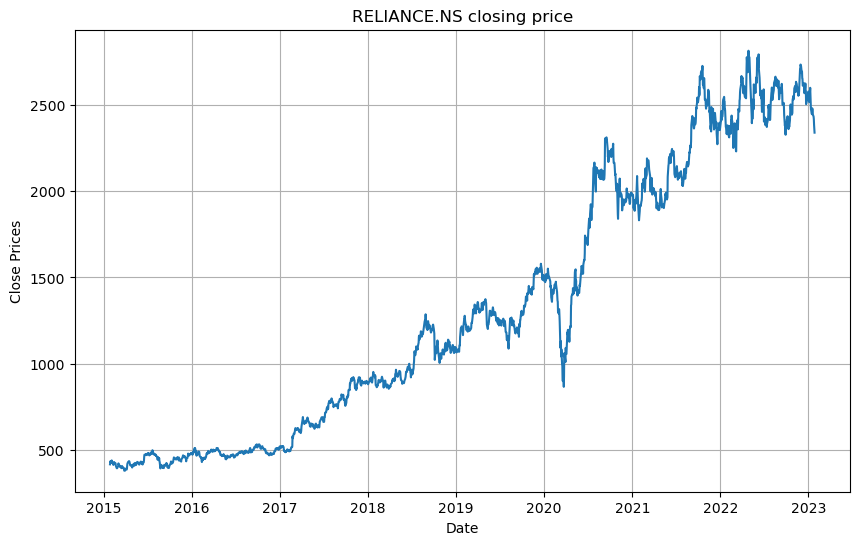

In [103]:
#Plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('{} closing price'.format(company_symbol))
plt.show()

<AxesSubplot:ylabel='Density'>

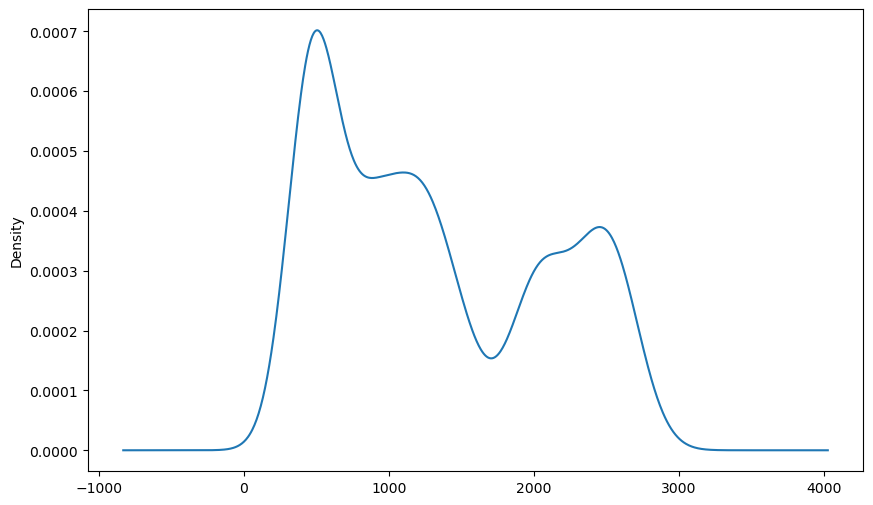

In [162]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

#### ADF (Augmented Dickey-Fuller) Test
ADF is used to determine whether the series has a unit root or not, therefore determining if series is stationary or not


- **Null Hypothesis**: The series has a unit root (value of a =1)
- **Alternate Hypothesis**: The series has no unit root.

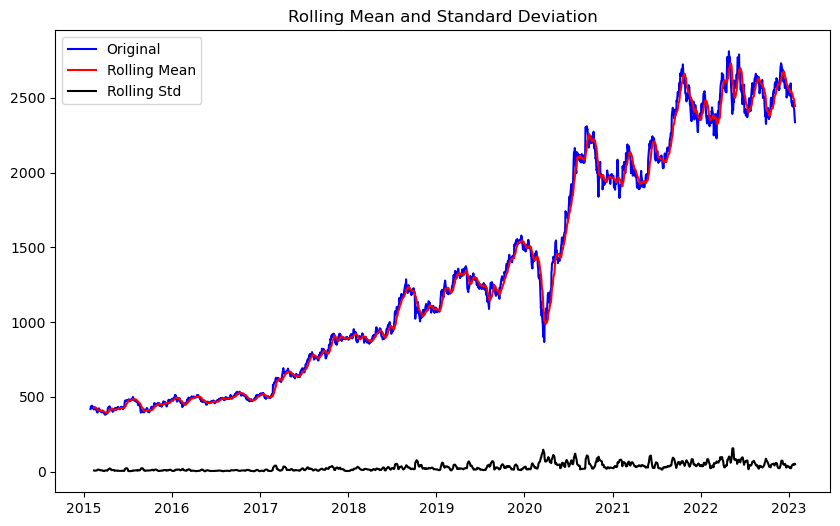

Results of dickey fuller test
Test Statistics                  -0.648161
p-value                           0.859724
No. of lags used                  5.000000
Number of observations used    1972.000000
critical value (1%)              -3.433670
critical value (5%)              -2.863007
critical value (10%)             -2.567551
dtype: float64



In [163]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output,end ='\n\n')
test_stationarity(df_close)

No handles with labels found to put in legend.


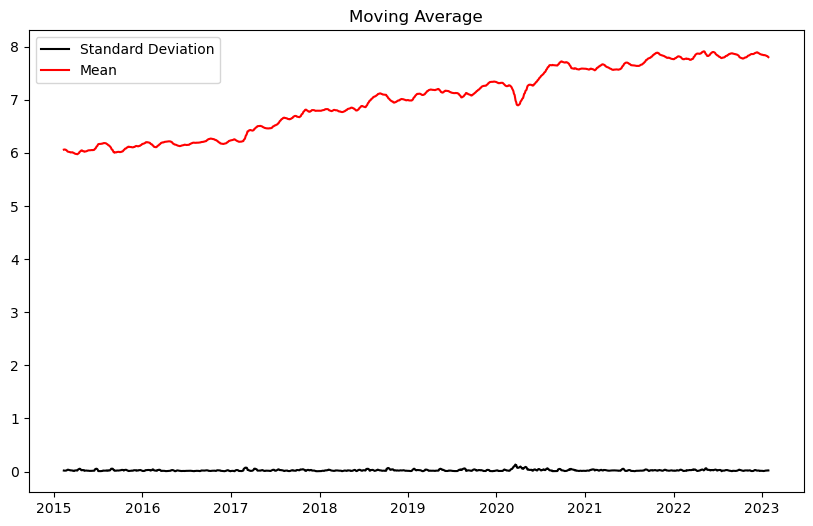

In [121]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

### Train model with best parameters

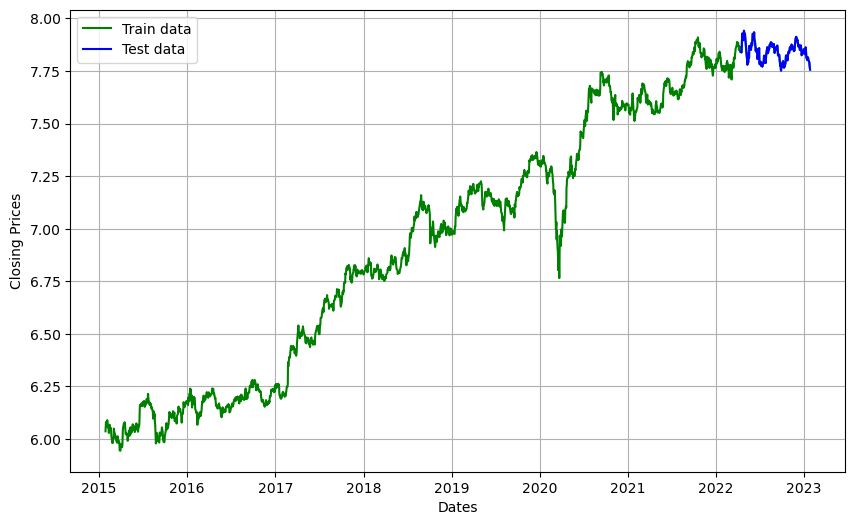

In [201]:
# Split data into train and test
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-8822.596, Time=4.06 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-4658.314, Time=0.18 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-8382.082, Time=1.82 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-6260.194, Time=2.19 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-4597.517, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-7948.539, Time=0.18 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=4.44 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=13.18 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-8380.834, Time=3.66 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=15.94 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=3.53 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.69 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=5.90 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-4656.860, Time=1.02 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : 

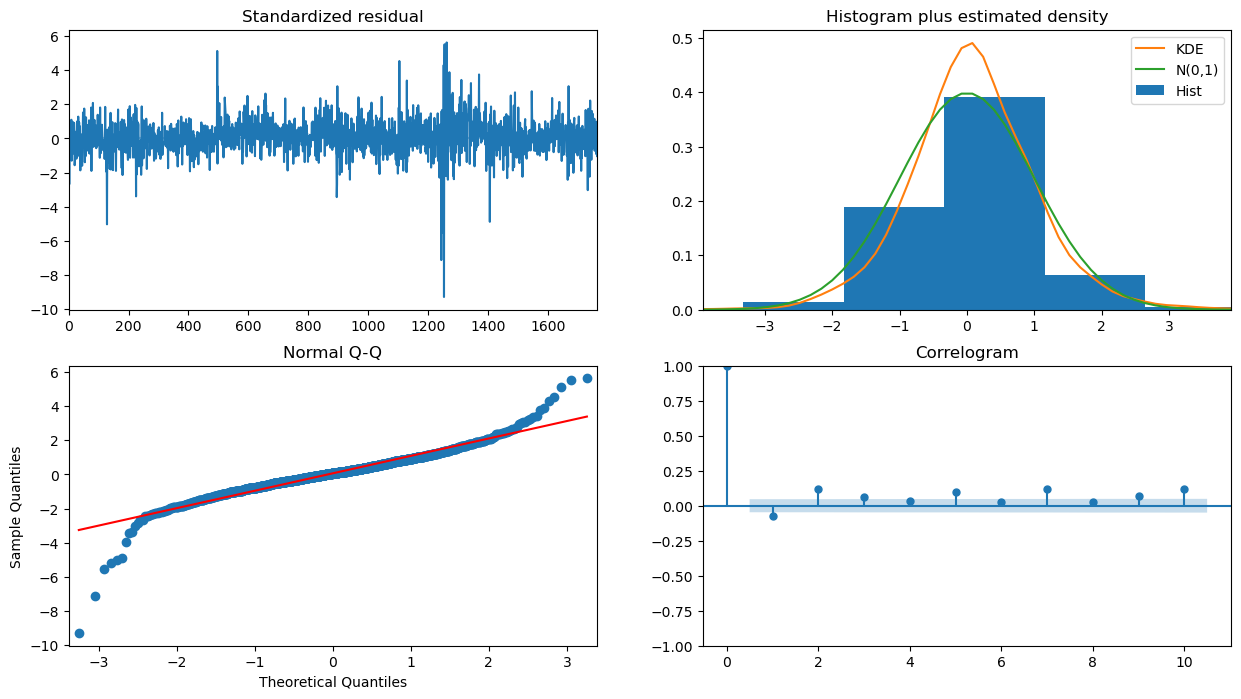

In [128]:
# Use auto_arima to find the best AR,I, and MA parameters for our model
stepwise_fit = auto_arima(train_data, start_p = 1, start_q = 1,
                            max_p = 3, max_q = 3, m = 12,
                            start_P = 0, seasonal = True,
                            d = None, D = 1, trace = True,
                            error_action ='ignore',
                            suppress_warnings = True,
                            stepwise = True)

print(stepwise_fit.summary())
stepwise_fit.plot_diagnostics(figsize=(15,8))
plt.show()

In [194]:
# Build Model
model = ARIMA(train_data, order=(1,0,1))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1777
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4551.698
Date:                Sat, 28 Jan 2023   AIC                          -9095.395
Time:                        17:35:14   BIC                          -9073.465
Sample:                             0   HQIC                         -9087.295
                               - 1777                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9053      0.632     10.932      0.000       5.667       8.143
ar.L1          0.9997      0.001   1265.017      0.000       0.998       1.001
ma.L1         -0.0165      0.014     -1.200      0.2

In [195]:
fit_array = fitted.forecast(321, alpha=0.05)  # 200 values with 95% conf

In [197]:
fit_array[:15]

1777    7.845196
1778    7.844916
1779    7.844636
1780    7.844356
1781    7.844077
1782    7.843797
1783    7.843518
1784    7.843239
1785    7.842959
1786    7.842680
1787    7.842401
1788    7.842122
1789    7.841843
1790    7.841564
1791    7.841286
Name: predicted_mean, dtype: float64

In [199]:
test_data['predicted']=fit_array

In [205]:
test_data

Date
2022-04-13    7.841489
2022-04-18    7.838428
2022-04-19    7.875831
2022-04-20    7.904811
2022-04-21    7.927955
2022-04-22    7.919545
2022-04-25    7.896147
2022-04-26    7.925634
2022-04-27    7.926606
2022-04-28    7.941433
2022-04-29    7.930880
2022-05-02    7.927362
2022-05-04    7.895646
2022-05-05    7.875869
2022-05-06    7.868171
2022-05-09    7.828333
2022-05-10    7.810848
2022-05-11    7.800551
2022-05-12    7.779968
2022-05-13    7.791240
2022-05-16    7.791487
2022-05-17    7.832632
2022-05-18    7.836263
2022-05-19    7.812947
2022-05-20    7.869620
2022-05-23    7.862911
2022-05-24    7.866338
2022-05-25    7.864865
2022-05-26    7.855287
2022-05-27    7.850637
2022-05-30    7.884878
2022-05-31    7.872740
2022-06-01    7.873063
2022-06-02    7.906961
2022-06-03    7.927020
2022-06-06    7.922712
2022-06-07    7.924589
2022-06-08    7.906869
2022-06-09    7.933922
2022-06-10    7.903265
2022-06-13    7.884165
2022-06-14    7.871010
2022-06-15    7.858836
2022-0